# Gaussian Mixture Models (GMMs)

The idea of GMMs is to describe generated data from a mixture of Gaussian distributions.
We have k different clusters, where every of those data clusters can be described by a different Gaussian.

Let $z$ be the latent variable that determines which cluster the data sample belongs to.

A generative process for GMMs is:
1. Sample a $z$ from its distribution $p(z | \theta)$, let's assume that it is a categorical distribution
2. Sample the data point from the distribution given by the cluster/Gaussian $z$

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [214]:
# in this case we sample the zs evenly
# we want to sample an equal amount of from each cluster
def sample_z(number_of_clusters, number_of_samples = 1):
    return np.random.choice(number_of_clusters, number_of_samples)

def sample_x_from( z_samples, means, covariances):
    xs = [np.random.multivariate_normal( means[z], covariances[z], 1)[0] for z in z_samples]
    return np.stack(xs)

def plot_2D_samples( samples, zs, figsize=(10,10) ):
    plt.figure(figsize=figsize)
    colors = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1)]
    for z in set(zs):
        z_samples = samples[ zs == z ]
        plt.scatter(z_samples[:,0], z_samples[:,1], c=[colors[z]])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("generated samples")

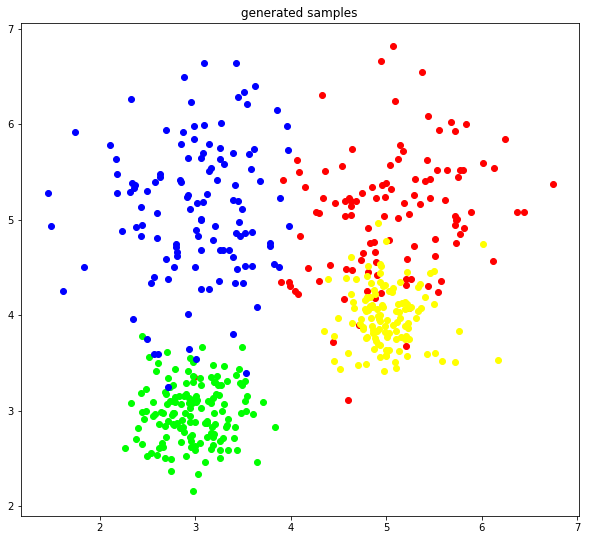

In [215]:
means = [
    [5,5],
    [3,3],
    [3,5],
    [5,4]
]
covariances = [
    [[0.4,0.1],[0.1,0.4]],
    [[0.1,0],[0,0.1]],
    [[0.3,0],[0,0.5]],
    [[0.1,0.0],[0.0,0.1]],
]

zs = sample_z(4, 500)
samples = sample_x_from( zs, means, np.array(covariances) )

plot_2D_samples(samples, zs)

# Learning and Inference
Now we understand how the generative process of a GMM works, we are still interested in two things

**Learning:** determine "optimal" values of the parameters ($\mu$, $\Sigma$)

**Inference:** assign points to clusters, $p(Z | X, \pi, \mu, \Sigma)$

# Inference

## $p(z_{ik} = 1 | x_i, \pi, \Sigma) = \frac{ p(z_{ik} | \pi) p(x_i | z_{ik}, \mu, \Sigma ) }{\sum_{j = 1}^K p(z_{ij} | \pi) p(x_i | z_{ij}, \mu, \Sigma)} = \frac{\pi_k N(x_i | \mu_k, \Sigma_k)}{\sum_{j = 1}^K \pi_j N(x_i | \mu_j, \Sigma_j)}$

This probability is also known as the responsibility of component k for the observation i.

### $\gamma(z_{ik}) = p(z_{ik} = 1 | x_i, \pi, \Sigma)$

In [217]:
from scipy.stats import multivariate_normal

def get_responsibilities( observed_data, pi, means, sigmas ):
    joint = np.zeros((len(observed_data), len(means)))
    for idx,(mean,sigma) in enumerate( zip(means,sigmas) ):
        joint[:,idx] = (pi[idx] * multivariate_normal.pdf(observed_data, mean, sigma))
    
    joint_sum = joint.sum(axis=1)
    
    for k in range(len(means)):
        joint[:,k] /= joint_sum
    return joint

def plot_2D_responsibilities( observed_data, responsibilities , figsize=(10,10)):
    plt.figure(figsize=figsize)
    colors = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1)]
    
    n, k = responsibilities.shape
    new_colors = np.empty((n,k,3))
    
    for cluster in range(k):
        new_colors [:,cluster,0] = responsibilities[:,cluster] * colors[cluster][0]
        new_colors [:,cluster,1] = responsibilities[:,cluster] * colors[cluster][1]
        new_colors [:,cluster,2] = responsibilities[:,cluster] * colors[cluster][2]
    new_colors = new_colors.sum(axis=1)
    
    plt.scatter( observed_data[:,0], observed_data[:,1], c=new_colors )
    plt.title("probability given means and covariances")    
    plt.gca().set_aspect('equal', adjustable='box')

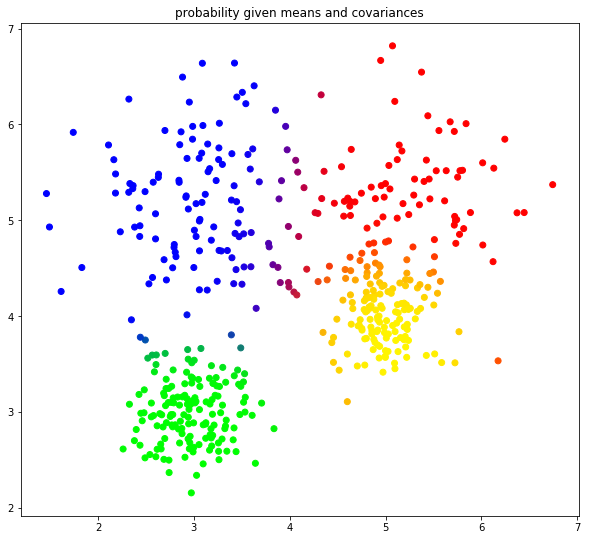

In [218]:
res = get_responsibilities( samples, len(means)*[1/len(means)], means, covariances)
plot_2D_responsibilities(samples, res)

In [222]:
means = [
    [5,5],
    [3,3],
    [3,5],
    [5,4]
]
covariances = [
    [[0.4,0.1],[0.1,0.4]],
    [[0.1,0],[0,0.1]],
    [[0.3,0],[0,0.5]],
    [[0.1,0.0],[0.0,0.1]],
]

zs = sample_z(4, 500)

def effect_of_sigma_scaling(scalar=1):
    cov = np.array(covariances) * scalar
    samples = sample_x_from( zs, means, cov )
    plot_2D_samples(samples, zs, figsize=(8,8))
    
    res = get_responsibilities( samples, len(means)*[1/len(means)], means, cov)
    plot_2D_responsibilities(samples, res, figsize=(8,8))

In [223]:
from ipywidgets import interact
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact( effect_of_sigma_scaling, scalar=(0.1,2.1))

interactive(children=(FloatSlider(value=1.0, description='scalar', max=2.1, min=0.1), Output()), _dom_classes=…

<function __main__.effect_of_sigma_scaling(scalar=1)>